In [ ]:
#Ideas: Chord Diagrams

In [1]:
#Import of preprocessedText Data
import pandas as pd

df = pd.read_csv("PreprocessedText.csv")
df.head()

,doc_id,country,year,strategy_name,file_name,text
0,CAN_2022,CAN,2022,Canada's National Quantum Strategy,CAN_2022_Canada's National Quantum Strategy.pdf,io executive summary advance quantum science p...
1,GER_2023,GER,2023,Quantum Technologies Conceptual Framework Prog...,GER_2023_Quantum Technologies Conceptual Frame...,1 exploit potential quantum technology germany...
2,UK_2023,UK,2023,National Quantum Strategy,UK_2023_National Quantum Strategy.pdf,ministerial foreword first generation quantum ...
3,USA_2018,USA,2018,NATIONAL STRATEGIC OVERVIEW FOR QUANTUM INFO...,USA_2018_NATIONAL STRATEGIC OVERVIEW FOR QUAN...,lsn report 2017 operationalizing software defi...


In [2]:
# Creation of Dictionary and Corpus 
QH_DICT = {
    "government": [
        "government", "state", "public sector", "ministry", "agency",
        "regulation", "policy", "legislation", "governance",
        "public funding", "subsidy", "public procurement"
    ],
    "society": [
        "society", "civil society", "citizen", "public", "community",
        "ngo", "non profit", "foundation", "participation",
        "public engagement", "social impact", "trust"
    ],
    "industry": [
        "industry", "business", "private sector", "company", "firm",
        "enterprise", "startup", "sme", "corporation",
        "commercialization", "market", "value chain"
    ],
    "academia": [
        "academia", "academic", "university", "higher education",
        "research institution", "research", "scientific",
        "laboratory", "technology transfer"
    ]
}


=== CAN | 2022 ===


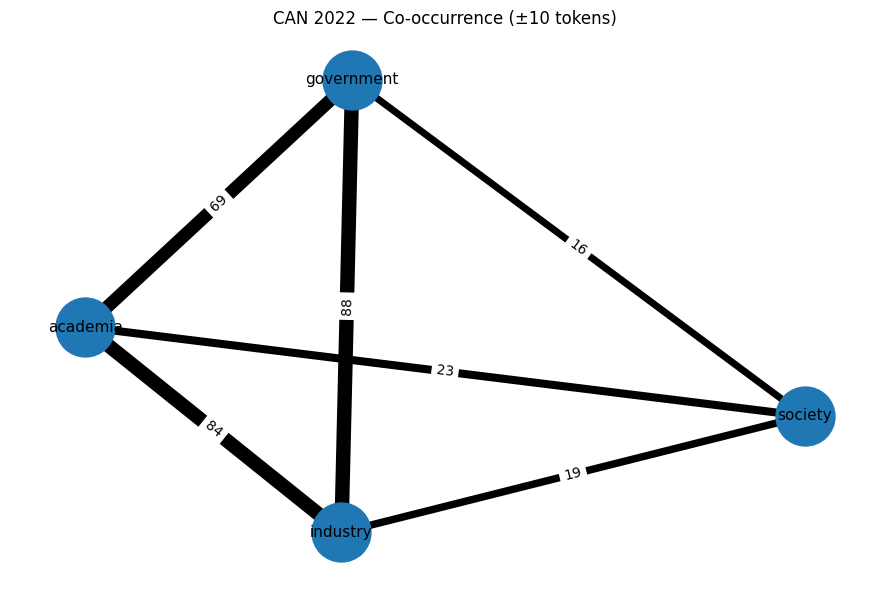

Edges with weights:
government -- industry: 88
industry -- academia: 84
government -- academia: 69
society -- academia: 23
society -- industry: 19
government -- society: 16

=== GER | 2023 ===


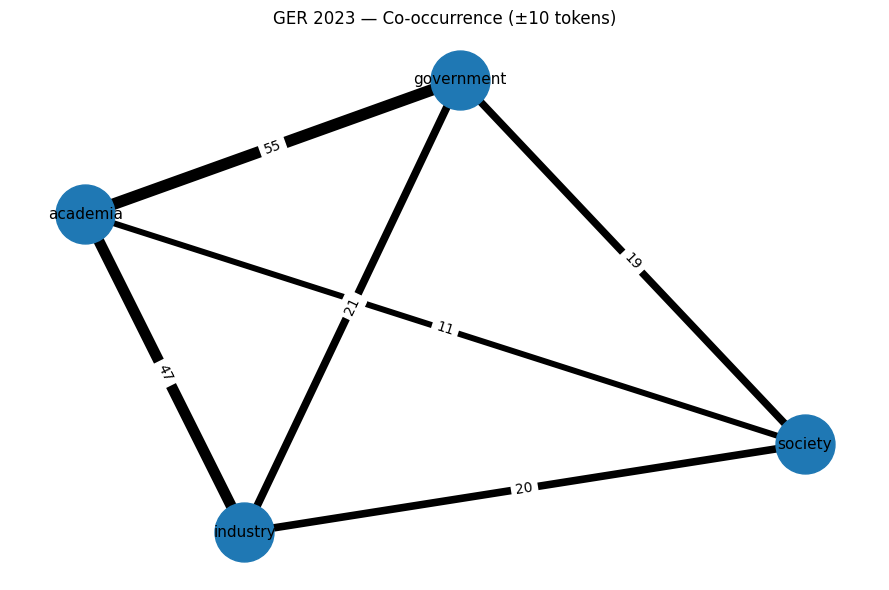

Edges with weights:
government -- academia: 55
industry -- academia: 47
government -- industry: 21
society -- industry: 20
government -- society: 19
society -- academia: 11

=== UK | 2023 ===


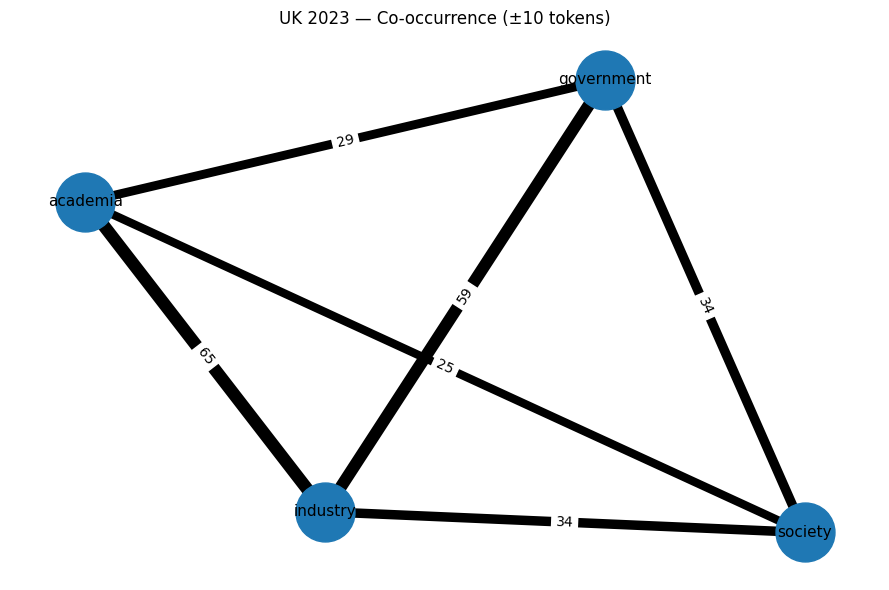

Edges with weights:
industry -- academia: 65
government -- industry: 59
government -- society: 34
society -- industry: 34
government -- academia: 29
society -- academia: 25

=== USA | 2018 ===


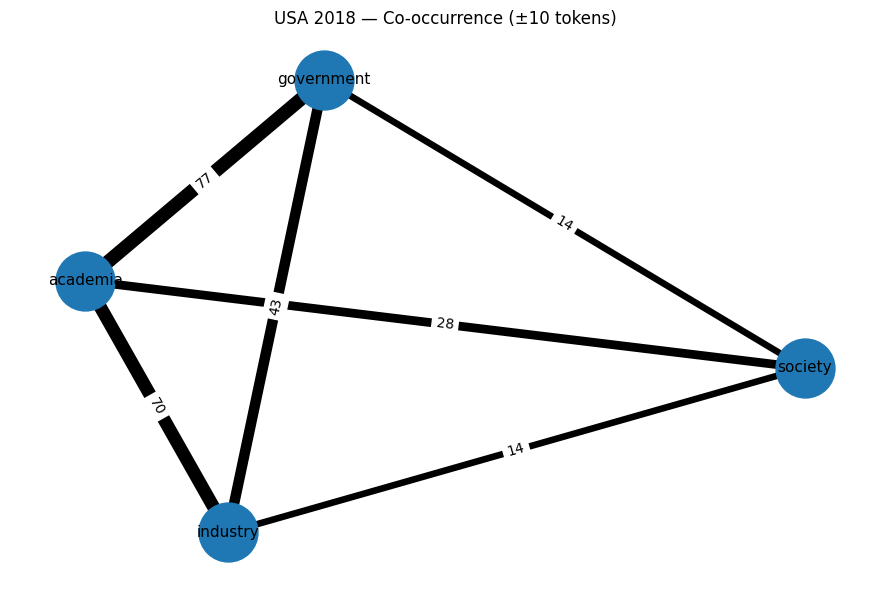

Edges with weights:
government -- academia: 77
industry -- academia: 70
government -- industry: 43
society -- academia: 28
government -- society: 14
society -- industry: 14


In [3]:
import pandas as pd
import re
from collections import defaultdict

import networkx as nx
import matplotlib.pyplot as plt

WINDOW = 10  # +/- tokens
_token_re = re.compile(r"[a-z0-9]+(?:'[a-z0-9]+)?", re.IGNORECASE)

def tokenize(text: str):
    return _token_re.findall(str(text).lower())

def find_phrase_positions(tokens, phrase_tokens):
    positions = []
    n = len(phrase_tokens)
    if n == 0 or len(tokens) < n:
        return positions
    for i in range(len(tokens) - n + 1):
        if tokens[i:i+n] == phrase_tokens:
            positions.append(i)
    return positions

# Pre-tokenize dictionary phrases (same as you had)
dict_phrase_tokens = {
    cat: [(term, tokenize(term)) for term in terms]
    for cat, terms in QH_DICT.items()
}

def edge_weights_for_texts(texts, window=WINDOW):
    """Compute category co-occurrence edge weights over a list of texts."""
    edge_weights = defaultdict(int)

    for text in texts:
        tokens = tokenize(text)

        occ = []
        for cat, term_list in dict_phrase_tokens.items():
            for term, ptoks in term_list:
                for pos in find_phrase_positions(tokens, ptoks):
                    occ.append((pos, cat))

        if len(occ) < 2:
            continue

        occ.sort(key=lambda x: x[0])

        # Correct window scan: reset j for each i
        for i in range(len(occ)):
            pi, ci = occ[i]
            j = i + 1
            while j < len(occ) and (occ[j][0] - pi) <= window:
                pj, cj = occ[j]
                if ci != cj:
                    a, b = sorted((ci, cj))
                    edge_weights[(a, b)] += 1
                j += 1

    return edge_weights

def plot_graph(edge_weights, country, year, window=WINDOW, min_weight=1, save_dir=None):
    G = nx.Graph()
    for cat in QH_DICT.keys():
        G.add_node(cat)

    for (a, b), w in edge_weights.items():
        if w >= min_weight:
            G.add_edge(a, b, weight=w)

    # ---- print header first (as you asked)
    print(f"\n=== {country} | {year} ===")

    if G.number_of_edges() == 0:
        print("No edges above threshold.")
        return

    pos = nx.spring_layout(G, seed=42, k=1.0)

    plt.figure(figsize=(9, 6))
    nx.draw_networkx_nodes(G, pos, node_size=1800)
    nx.draw_networkx_labels(G, pos, font_size=11)

    weights = [G[u][v]["weight"] for u, v in G.edges()]
    widths = [1 + (w ** 0.5) for w in weights]
    nx.draw_networkx_edges(G, pos, width=widths)

    edge_labels = {(u, v): G[u][v]["weight"] for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    plt.title(f"{country} {year} — Co-occurrence (±{window} tokens)")
    plt.axis("off")
    plt.tight_layout()

    if save_dir is not None:
        import os
        os.makedirs(save_dir, exist_ok=True)
        fn = f"{country}_{year}_coocc_window{window}.png".replace(" ", "_")
        plt.savefig(os.path.join(save_dir, fn), dpi=200, bbox_inches="tight")

    plt.show()

    print("Edges with weights:")
    for (u, v, d) in sorted(G.edges(data=True), key=lambda x: -x[2]["weight"]):
        print(f"{u} -- {v}: {d['weight']}")

# -------------------------
# MAKE A GRAPH FOR EACH (country, year)
# -------------------------
# Assumes df has columns: ["country", "year", "text"]
for (country, year), g in df.groupby(["country", "year"], sort=True):
    ew = edge_weights_for_texts(g["text"].tolist(), window=WINDOW)
    plot_graph(ew, country, year, window=WINDOW, min_weight=1, save_dir=None)  # set save_dir="graphs" to save


In [ ]:
import pandas as pd
import re
from itertools import combinations
from collections import defaultdict

import networkx as nx
import matplotlib.pyplot as plt

WINDOW = 20  # +/- 20 tokens

# -------------------------
# 3) Helpers (tokenization + phrase matching)
# -------------------------
_token_re = re.compile(r"[a-z0-9]+(?:'[a-z0-9]+)?", re.IGNORECASE)

def tokenize(text: str):
    return _token_re.findall(text.lower())

def find_phrase_positions(tokens, phrase_tokens):
    """Return start indices where phrase_tokens matches tokens."""
    positions = []
    n = len(phrase_tokens)
    if n == 0 or len(tokens) < n:
        return positions
    for i in range(len(tokens) - n + 1):
        if tokens[i:i+n] == phrase_tokens:
            positions.append(i)
    return positions

# Pre-tokenize dictionary phrases
dict_phrase_tokens = {
    cat: [(term, tokenize(term)) for term in terms]
    for cat, terms in QH_DICT.items()
}

# -------------------------
# 4) Count co-occurrences between CATEGORIES within +/- WINDOW tokens
# -------------------------
edge_weights = defaultdict(int)

for text in df["text"]:
    tokens = tokenize(text)

    # collect occurrences as (position, category)
    occ = []
    for cat, term_list in dict_phrase_tokens.items():
        for term, ptoks in term_list:
            for pos in find_phrase_positions(tokens, ptoks):
                occ.append((pos, cat))

    if len(occ) < 2:
        continue

    # sort by position for efficient window pairing
    occ.sort(key=lambda x: x[0])

    # two-pointer window scan: for each i, compare to following j within WINDOW
    j = 0
    for i in range(len(occ)):
        pi, ci = occ[i]
        if j < i + 1:
            j = i + 1
        while j < len(occ) and occ[j][0] - pi <= WINDOW:
            pj, cj = occ[j]
            if ci != cj:
                a, b = sorted((ci, cj))
                edge_weights[(a, b)] += 1
            j += 1

# -------------------------
# 5) Build graph + draw with numbers
# -------------------------
G = nx.Graph()
for cat in QH_DICT.keys():
    G.add_node(cat)

for (a, b), w in edge_weights.items():
    if w > 0:
        G.add_edge(a, b, weight=w)

# draw
pos = nx.spring_layout(G, seed=42, k=1.0)

plt.figure(figsize=(9, 6))
nx.draw_networkx_nodes(G, pos, node_size=1800)
nx.draw_networkx_labels(G, pos, font_size=11)

# edge widths scaled by weight (but still simple)
weights = [G[u][v]["weight"] for u, v in G.edges()]
widths = [1 + (w ** 0.5) for w in weights]  # sqrt so it doesn't explode
nx.draw_networkx_edges(G, pos, width=widths)

# edge labels = actual counts
edge_labels = {(u, v): G[u][v]["weight"] for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title(f"Co-occurrence Network (±{WINDOW} tokens), edge labels = counts")
plt.axis("off")
plt.tight_layout()
plt.show()

print("Edges with weights:")
for (u, v, d) in sorted(G.edges(data=True), key=lambda x: -x[2]["weight"]):
    print(f"{u} -- {v}: {d['weight']}")

In [ ]:
import pandas as pd
import itertools
from collections import defaultdict, Counter

import spacy
from spacy.matcher import PhraseMatcher

import networkx as nx
import matplotlib.pyplot as plt

WINDOW = 20  # +/- 20 words (tokens)

# --- Build keyword -> topic map (cluster keywords into overall topic) ---
kw_to_topic = {}
all_keywords = []
for topic, kws in QH_DICT.items():
    for kw in kws:
        kw_l = kw.lower().strip()
        kw_to_topic[kw_l] = topic
        all_keywords.append(kw_l)

# --- Phrase matching (handles multi-word phrases like "public sector") ---
nlp = spacy.blank("en")  # no model download needed
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
patterns = [nlp.make_doc(k) for k in all_keywords]
matcher.add("QH_KWS", patterns)

# --- Count co-occurrences within window, based on token distance ---
edge_counts = defaultdict(int)
node_counts = Counter()

for doc in nlp.pipe(df['text'], batch_size=32):
    matches = matcher(doc)

    # store (start_token_index, matched_phrase)
    hits = []
    for _, start, end in matches:
        phrase = doc[start:end].text.lower().strip()
        hits.append((start, phrase))
        node_counts[phrase] += 1

    # sort by position to enable efficient window checks
    hits.sort(key=lambda x: x[0])

    # for each pair within WINDOW tokens -> increment edge
    for i in range(len(hits)):
        pos_i, kw_i = hits[i]
        j = i + 1
        while j < len(hits) and (hits[j][0] - pos_i) <= WINDOW:
            pos_j, kw_j = hits[j]
            if kw_i != kw_j:
                a, b = sorted([kw_i, kw_j])
                edge_counts[(a, b)] += 1
            j += 1

# --- Build keyword-level graph ---
G_kw = nx.Graph()
for kw in all_keywords:
    G_kw.add_node(
        kw,
        topic=kw_to_topic.get(kw, "unknown"),
        freq=node_counts.get(kw, 0)
    )

for (a, b), w in edge_counts.items():
    if w > 0:
        G_kw.add_edge(a, b, weight=w)

print("Keyword nodes:", G_kw.number_of_nodes())
print("Keyword edges:", G_kw.number_of_edges())

# --- Plot keyword-level network with edge weight labels ---
topic_colors = {
    "government": "tab:blue",
    "society": "tab:green",
    "industry": "tab:orange",
    "academia": "tab:purple",
    "unknown": "tab:gray"
}

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G_kw, seed=42, k=0.8)

node_color = [topic_colors.get(G_kw.nodes[n]["topic"], "tab:gray") for n in G_kw.nodes]
node_size = [max(80, 20 * G_kw.nodes[n].get("freq", 0)) for n in G_kw.nodes]  # scale by keyword frequency

nx.draw_networkx_nodes(G_kw, pos, node_color=node_color, node_size=node_size, alpha=0.9)
nx.draw_networkx_labels(G_kw, pos, font_size=8)

# edge widths scaled by weight
weights = [G_kw[u][v]["weight"] for u, v in G_kw.edges]
edge_widths = [0.5 + 0.4 * w for w in weights]
nx.draw_networkx_edges(G_kw, pos, width=edge_widths, alpha=0.5)

# show numbers on edges (co-occurrence counts)
edge_labels = {(u, v): G_kw[u][v]["weight"] for u, v in G_kw.edges}
nx.draw_networkx_edge_labels(G_kw, pos, edge_labels=edge_labels, font_size=7)

plt.title(f"Keyword co-occurrence network (±{WINDOW} words)")
plt.axis("off")
plt.show()

G_topic = nx.Graph()
for t in QH_DICT.keys():
    G_topic.add_node(t)

for (a, b), w in edge_counts.items():
    ta = kw_to_topic.get(a, "unknown")
    tb = kw_to_topic.get(b, "unknown")
    if ta == "unknown" or tb == "unknown" or ta == tb:
        continue
    x, y = sorted([ta, tb])
    if G_topic.has_edge(x, y):
        G_topic[x][y]["weight"] += w
    else:
        G_topic.add_edge(x, y, weight=w)

plt.figure(figsize=(8, 6))
pos2 = nx.spring_layout(G_topic, seed=42)

nx.draw_networkx_nodes(
    G_topic, pos2,
    node_size=1200,
    node_color=[topic_colors[t] for t in G_topic.nodes],
    alpha=0.9
)
nx.draw_networkx_labels(G_topic, pos2, font_size=10)

w2 = [G_topic[u][v]["weight"] for u, v in G_topic.edges]
nx.draw_networkx_edges(G_topic, pos2, width=[0.8 + 0.1*x for x in w2], alpha=0.6)

edge_labels2 = {(u, v): G_topic[u][v]["weight"] for u, v in G_topic.edges}
nx.draw_networkx_edge_labels(G_topic, pos2, edge_labels=edge_labels2, font_size=9)

plt.title(f"Topic co-occurrence network (from keyword co-occurrences, ±{WINDOW} words)")
plt.axis("off")
plt.show()


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
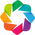

In [4]:
import pandas as pd
import holoviews as hv
from holoviews import opts

# Initialize Holoviews with Bokeh backend
hv.extension('bokeh')

def plot_chord_diagram(edge_weights, country, year, min_weight=1):
    """Transforms edge weights into an interactive Chord Diagram."""
    
    # 1. Convert edge_weights dictionary to a DataFrame format required by Holoviews
    links_data = []
    for (source, target), weight in edge_weights.items():
        if weight >= min_weight:
            links_data.append({'source': source, 'target': target, 'value': weight})
    
    if not links_data:
        print(f"=== {country} | {year} ===\nNo edges above threshold.")
        return

    links_df = pd.DataFrame(links_data)

    # 2. Define the Chord object
    # We use 'source', 'target', and 'value' (weight)
    chord = hv.Chord(links_df)

    # 3. Apply styling
    chord.opts(
        opts.Chord(
            cmap='Category20',
            edge_cmap='Category20',
            edge_color=hv.dim('source').str(),
            node_color=hv.dim('index').str(),
            labels='index',
            width=600, 
            height=600,
            title=f"Co-occurrence: {country} {year}",
            label_text_font_size='10pt'
        )
    )

    # Display the plot
    # Note: In Jupyter, this renders automatically. 
    # To save as HTML: hv.save(chord, f'{country}_{year}.html')
    return chord

# -------------------------
# EXECUTION LOOP
# -------------------------
for (country, year), g in df.groupby(["country", "year"], sort=True):
    ew = edge_weights_for_texts(g["text"].tolist(), window=WINDOW)
    # This will return a list of interactive plots
    plot_chord_diagram(ew, country, year)